# Training the CNN model

In [2]:
sys.path.insert(1, '../src')
import app_constants as const
import matplotlib.pyplot as plt
import numpy as np

#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D, Input
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix

In [8]:
#provides easy way to transform images.
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

train_dataset = image_generator.flow_from_directory(
                                                 directory=const.DATA_DIR,
                                                 shuffle=True,
                                                 target_size=(256, 256), 
                                                 batch_size=32,
                                                 subset="training",
                                                 class_mode='categorical',
                                                 classes=const.LABELS,
                                                 color_mode="grayscale")

valid_dataset = image_generator.flow_from_directory(
                                                 directory=const.DATA_DIR,
                                                 shuffle=True,
                                                 target_size=(256, 256), 
                                                 batch_size=32,
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 classes=const.LABELS,
                                                 color_mode="grayscale")

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.
[0 0 0 ... 2 2 2]


# =============================================================================
# Model 1
# =============================================================================

In [ ]:
# initializing the CNN
model = Sequential()
# Convolution layer-1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Convolution layer-2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Convolution layer-3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# flattening layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Output layer
model.add(Dense(const.NUM_CATEGORY, activation='softmax')) # because we have 3 classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

# To avoid overfitting. Stop if no improvement in epochs
early_stopping = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          patience=100,
                          verbose = 1,
                          restore_best_weights = True)

# Save model after every epoch
model_check_point = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model1"),
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# Reduce learning rate 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [early_stopping , model_check_point, learning_rate_reduction]

In [ ]:
classifier = model.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks],
                    verbose=1)

In [ ]:

y_pred = model.predict(valid_dataset)

In [ ]:
print(classifier.history["accuracy"])

In [ ]:
model.save(const.get_model_path("model1"))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier.history['loss'], color='b', label="Training loss")
ax1.plot(classifier.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Graph of training loss & validation loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(classifier.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("Graph of training accuracy & validation accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# =============================================================================
# Model 2
# =============================================================================


In [ ]:
model_two = Sequential()
# Convolution layer-1
model_two.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer-2
model_two.add(Conv2D(64, (3, 3), activation='relu'))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer-3
model_two.add(Conv2D(128, (3, 3), activation='relu'))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer-4
model_two.add(Conv2D(256, (3, 3), activation='relu'))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# flattening layer
model_two.add(Flatten())
model_two.add(Dense(256, activation='relu'))

# Output layer
model_two.add(Dense(const.NUM_CATEGORY, activation='sigmoid'))

model_two.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_two.summary()

In [ ]:
# To avoid overfitting. Stop if no improvement in epochs
early_stopping_2 = EarlyStopping(monitor = 'loss',
                          mode = 'min',
                          patience=10,
                          verbose = 1,
                          restore_best_weights = True)

# Save model after every epoch
model_check_point_2 = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model2"),
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# Reduce learning rate 
learning_rate_reduction_2 = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.001)
callbacks_2 = [early_stopping_2 , model_check_point_2, learning_rate_reduction_2]

In [ ]:
classifier2 = model_two.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks_2],
                    verbose=1)

In [ ]:

y_pred2 = model_two.predict(valid_dataset)

In [ ]:
model_two.save(const.get_model_path("model2"))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier2.history['loss'], color='b', label="Training loss")
ax1.plot(classifier2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Graph of training loss & validation loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(classifier2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("Graph of training accuracy & validation accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# =============================================================================
# Model 3
# =============================================================================

In [ ]:
# Model 3
model_three = Sequential()

# Convolution layer-1
model_three.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(256, 256, 1)))
model_three.add(BatchNormalization())

# Convolution layer-2
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model3.add(BatchNormalization())
model_three.add(MaxPooling2D(pool_size = (2, 2)))
model_three.add(Dropout(0.25))

# Convolution layer-3
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_three.add(BatchNormalization())

# Convolution layer-4
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model3.add(BatchNormalization())
model_three.add(AveragePooling2D(pool_size=(2, 2)))
model_three.add(Dropout(0.25))

# Convolution layer-5
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model3.add(BatchNormalization())
model_three.add(MaxPooling2D(pool_size = (2, 2)))
model_three.add(Dropout(0.25))

# Convolution layer-6
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_three.add(BatchNormalization())

# Convolution layer-7
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_three.add(BatchNormalization())
model_three.add(AveragePooling2D(pool_size=(2, 2)))
model_three.add(Dropout(0.25))

# flattening layer
model_three.add(Flatten())
model_three.add(BatchNormalization())
model_three.add(Dense(128, activation='relu'))
model_three.add(Activation('relu'))
model_three.add(Dropout(0.25))

# Output layer
model_three.add(BatchNormalization())
model_three.add(Dense(const.NUM_CATEGORY, activation='softmax'))
model_three.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=[Recall()])
model_three.summary()

In [ ]:
early_stopping_3 = EarlyStopping(monitor='val_loss',
                               mode = 'min',
                               patience=5,
                               verbose=1)

# Save model after every epoch
model_check_point_3 = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model3"),
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# Reduce learning rate 
learning_rate_reduction_3 = ReduceLROnPlateau(monitor='val_recall_3', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks_3 = [early_stopping_3 , model_check_point_3, learning_rate_reduction_3]

In [ ]:
classifier3 = model_three.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks_3],
                    verbose=1)

In [ ]:

y_pred3 = model_three.predict(valid_dataset)

In [ ]:
model_two.save(const.get_model_path("model3"))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier3.history['loss'], color='b', label="Training loss")
ax1.plot(classifier3.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Graph of training loss & validation loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier3.history['recall_2'], color='b', label="Training accuracy")
ax2.plot(classifier3.history['val_recall_2'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("Graph of training accuracy & validation accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# =============================================================================
# VGG16 Model
# =============================================================================

https://www.kaggle.com/subhanjanbasu/dogs-cats-classifier-using-vgg16-and-densenet201

https://www.kaggle.com/abhaymudgal/dogs-vs-cats

https://keras.io/api/applications/vgg/

https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [109]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

train_dataset_vgg = image_generator.flow_from_directory(
                                                 directory=const.DATA_DIR,
                                                 shuffle=True,
                                                 target_size=(256, 256), 
                                                 batch_size=32,
                                                 subset="training",
                                                 class_mode='categorical',
                                                 classes=const.LABELS,
                                                 color_mode="rgb")

valid_dataset_vgg = image_generator.flow_from_directory(
                                                 directory=const.DATA_DIR,
                                                 shuffle=True,
                                                 target_size=(256, 256), 
                                                 batch_size=32,
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 classes=const.LABELS,
                                                 color_mode="rgb")

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


In [110]:
base_conv = VGG16(weights='imagenet',
                 include_top=False,
                 input_tensor= Input(shape=(256,256, 3))
                )
base_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [111]:
base_conv.trainable = False

In [112]:
vgg_model = Sequential()
vgg_model.add(base_conv)

# Flatten layer
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))

# Create new model on top.
inputs = keras.Input(shape=(256, 256, 3))
x = vgg_model(inputs, training=False)
outputs = keras.layers.Dense(3)(x)
model_vgg = keras.Model(inputs, outputs)


model_vgg.compile(loss='categorical_crossentropy',
             optimizer = keras.optimizers.Adam(),
             metrics = ['acc'])
model_vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 256)               23103552  
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 771       
Total params: 23,104,323
Trainable params: 8,389,635
Non-trainable params: 14,714,688
_________________________________________________________________


In [113]:
early_stopping_vgg = EarlyStopping(monitor='acc',
                                 patience=2,
                                 verbose=1)
# Save model after every epoch
model_check_point_vgg = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model_vgg"),
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

callbacks_vgg = [early_stopping_vgg , model_check_point_vgg]

In [114]:
classifier_vgg = model_vgg.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks_vgg],
                    verbose=1)

Epoch 1/20
23/23 [==============================] - 496s 22s/step - loss: 1.9503 - acc: 0.1778 - val_loss: 0.8724 - val_acc: 0.0938

Epoch 00001: loss improved from inf to 1.22340, saving model to ../model/model_vgg_temp.h5
Epoch 2/20
23/23 [==============================] - 649s 29s/step - loss: 0.8157 - acc: 0.0632 - val_loss: 0.7590 - val_acc: 0.0875

Epoch 00002: loss improved from 1.22340 to 0.76963, saving model to ../model/model_vgg_temp.h5
Epoch 3/20
23/23 [==============================] - 766s 34s/step - loss: 0.6498 - acc: 0.0886 - val_loss: 0.5315 - val_acc: 0.1000

Epoch 00003: loss improved from 0.76963 to 0.62938, saving model to ../model/model_vgg_temp.h5
Epoch 00003: early stopping


In [116]:

y_pred_vgg = model_vgg.predict(valid_dataset)

In [117]:
model_vgg.save(const.get_model_path("model_vgg"))

In [119]:
classifier_vgg.history

{'loss': [1.2234021425247192, 0.769631028175354, 0.6293797492980957],
 'acc': [0.10869564861059189, 0.075239397585392, 0.09646739065647125],
 'val_loss': [0.8724403381347656, 0.7590339779853821, 0.5315092206001282],
 'val_acc': [0.09375, 0.08749999850988388, 0.10000000149011612]}

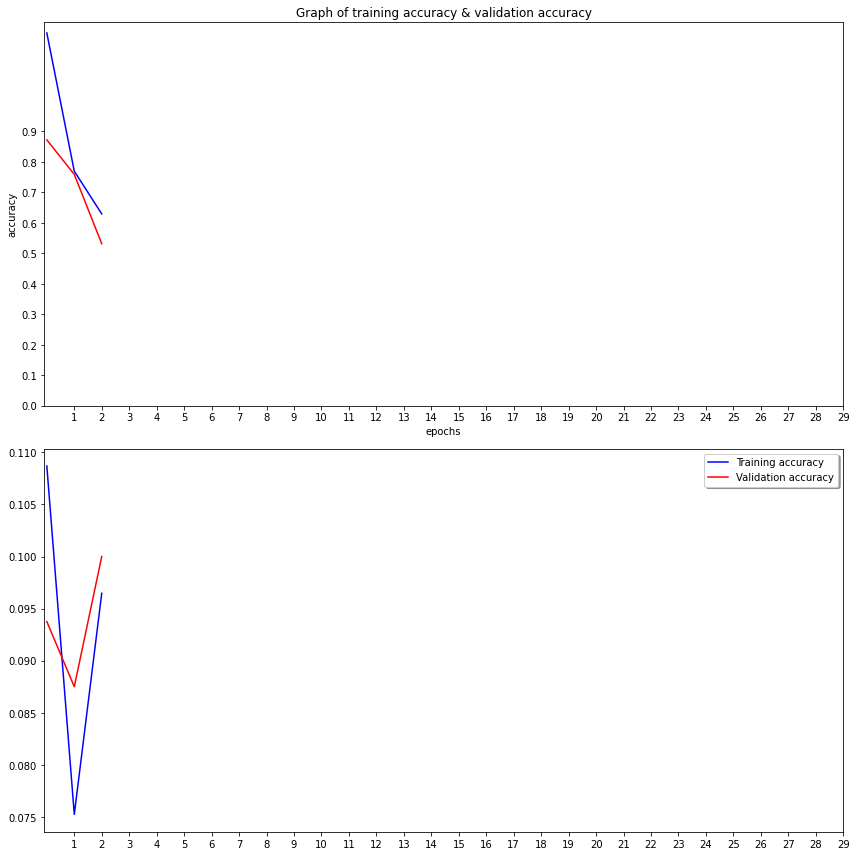

In [120]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier_vgg.history['loss'], color='b', label="Training loss")
ax1.plot(classifier_vgg.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Graph of training loss & validation loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier_vgg.history['acc'], color='b', label="Training accuracy")
ax2.plot(classifier_vgg.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("Graph of training accuracy & validation accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# =============================================================================
# DenseNet
# =============================================================================

https://arxiv.org/abs/1608.06993